# Predicting Quarterly Stock Return Type with SEC Data

## Introduction
The objective of this project is to predict the quarterly return type of a stock. The data contains financial ratios from the SEC financial and notes datasets, previously scrapped stock data, and daily stock information from the iexfinance.stocks api. The dates range from Q1 2009 to Q3 2018

## Approach
I decided early on for this project that it didn't matter much whether I got the exact price for the return but it is more important that they fall into the correct categories. So I broke the log rate of returns into 5 categories.

1.  **High negative return** - log rate of return is <= -0.10
2.  **Negative return** - log rate of return between -0.10 and -0.0075
3.  **No return** - log rate of return between -0.0075 and 0.0075
4.  **Positive return** - log rate of return between 0.0075 and 0.10
5.  **High positive return** - log rate of return is >= 0.10

The reasoning for choosing 5 categories instead of simply positive return and negative return is that we want to know the degree of the return. The rates themselves are mostly arbitrary. I chose ±0.10 because many consider that to be an average return for a yearly return. So getting that return for a single quarter is a good measure for declaring a high return. The no return range of ±0.0075 is a quarter of the historic annual rate of inflation.

I picked the basic financial numbers because they allowed me to calculate most of the financial ratios and they were common in the SEC filings.

For information about the columns in the beginning dataset check [column_info.md](reports\column_info.md)

## EDA

In [1]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# allows use of custom functions
if __name__ == '__main__' and __package__ is None:
    from os import sys, path
    sys.path.append(path.dirname(path.dirname(path.abspath("__file__"))))

# dataframe formatting
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

### Data Read-In and Summary

In [2]:
financial_ratios = pd.read_csv(
    Path("../data/processed_data/sec_and_stock_dataset.csv"),
    parse_dates=['period', 'next_period'],
    dtype={'cik': 'str'})
financial_ratios.head()

,adsh,cik,name,ticker,sector,period,stock_price,next_period,next_period_price,beta,assets,earnings_per_share_basic,liabilities,net_income_loss,stockholders_equity,weighted_shares_outstanding_basic
0,0000732717-09-000050,732717,AT&T INC.,T,PUBLIC UTILITIES,2009-06-30,24.840,2009-09-30,27.010,0.533,"267,918,000,000.000",0.540,nan,"3,198,000,000.000",nan,nan
1,0000950123-09-027630,54480,KANSAS CITY SOUTHERN,KSU,TRANSPORTATION,2009-06-30,16.110,2009-09-30,26.490,1.909,"5,366,500,000.000",0.070,"3,112,700,000.000","6,800,000.000","1,970,100,000.000","91,955,000.000"
2,0000950123-09-029672,200406,JOHNSON & JOHNSON,JNJ,HEALTH CARE,2009-06-30,56.800,2009-09-30,60.890,0.287,"87,438,000,000.000",1.160,"41,191,000,000.000",nan,nan,"2,756,200,000.000"
3,0000950123-09-029713,1163165,CONOCOPHILLIPS,COP,ENERGY,2009-06-30,32.063,2009-09-30,34.426,1.230,"150,073,000,000.000",0.870,"90,066,000,000.000","1,298,000,000.000","58,929,000,000.000","1,486,496.000"
4,0000950123-09-032832,19617,J P MORGAN CHASE & CO,JPM,FINANCE,2009-06-30,34.110,2009-09-30,43.820,2.432,"2,026,642,000,000.000",0.280,"1,871,876,000,000.000","2,721,000,000.000","154,766,000,000.000","3,811,500,000.000"


In [3]:
financial_ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20333 entries, 0 to 20332
Data columns (total 16 columns):
adsh                                 20333 non-null object
cik                                  20333 non-null object
name                                 20333 non-null object
ticker                               20333 non-null object
sector                               20198 non-null object
period                               20333 non-null datetime64[ns]
stock_price                          20333 non-null float64
next_period                          20333 non-null datetime64[ns]
next_period_price                    20171 non-null float64
beta                                 20306 non-null float64
assets                               20279 non-null float64
earnings_per_share_basic             12588 non-null float64
liabilities                          17252 non-null float64
net_income_loss                      16470 non-null float64
stockholders_equity                  18088

### Fill in missing values
For many of most of the columns there are more than a few missing values. There isn't much we can do for a some of them. But one of the foundations of Accounting is that Assets = Liabilities + Stockholders Equity. Using that formula we can fill in at least some of the missing values from those columns.

In [4]:
financial_ratios['assets'] = financial_ratios['assets'].fillna(
    financial_ratios['liabilities'] + financial_ratios['stockholders_equity'])

financial_ratios['liabilities'] = financial_ratios['liabilities'].fillna(
    financial_ratios['assets'] - financial_ratios['stockholders_equity'])

financial_ratios['stockholders_equity'] = financial_ratios['stockholders_equity'].fillna(
    financial_ratios['assets'] - financial_ratios['liabilities'])

Unfortunately filling in more missing values requires more data than we currently have on hand. Our only course of action now is to remove the filings that have missing values.

In [5]:
financial_ratios = financial_ratios.dropna()
financial_ratios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8896 entries, 1 to 20332
Data columns (total 16 columns):
adsh                                 8896 non-null object
cik                                  8896 non-null object
name                                 8896 non-null object
ticker                               8896 non-null object
sector                               8896 non-null object
period                               8896 non-null datetime64[ns]
stock_price                          8896 non-null float64
next_period                          8896 non-null datetime64[ns]
next_period_price                    8896 non-null float64
beta                                 8896 non-null float64
assets                               8896 non-null float64
earnings_per_share_basic             8896 non-null float64
liabilities                          8896 non-null float64
net_income_loss                      8896 non-null float64
stockholders_equity                  8896 non-null float6

## Creating the Target Variable

  **This dataset doesn't contain our target variable. It doesn't matter to us what the exact rate of return will be.**


In [6]:
financial_ratios['log_rate_of_return'] = (
  np.log(financial_ratios['next_period_price']) -
  np.log(financial_ratios['stock_price']))

financial_ratios.loc[:,'return_type'] = 'high_negative'
financial_ratios.loc[financial_ratios['log_rate_of_return'] > -0.1,'return_type'] = 'negative'
financial_ratios.loc[financial_ratios['log_rate_of_return'] >= -(.03/4), 'return_type'] = 'no return'
financial_ratios.loc[financial_ratios['log_rate_of_return'] >= (.03/4), 'return_type'] = 'positive'
financial_ratios.loc[financial_ratios['log_rate_of_return'] >= 0.1, 'return_type'] = 'high_positive'

financial_ratios.head()

,adsh,cik,name,ticker,sector,period,stock_price,next_period,next_period_price,beta,assets,earnings_per_share_basic,liabilities,net_income_loss,stockholders_equity,weighted_shares_outstanding_basic,log_rate_of_return,return_type
1,0000950123-09-027630,54480,KANSAS CITY SOUTHERN,KSU,TRANSPORTATION,2009-06-30,16.110,2009-09-30,26.490,1.909,"5,366,500,000.000",0.070,"3,112,700,000.000","6,800,000.000","1,970,100,000.000","91,955,000.000",0.497,high_positive
3,0000950123-09-029713,1163165,CONOCOPHILLIPS,COP,ENERGY,2009-06-30,32.063,2009-09-30,34.426,1.230,"150,073,000,000.000",0.870,"90,066,000,000.000","1,298,000,000.000","58,929,000,000.000","1,486,496.000",0.071,positive
4,0000950123-09-032832,19617,J P MORGAN CHASE & CO,JPM,FINANCE,2009-06-30,34.110,2009-09-30,43.820,2.432,"2,026,642,000,000.000",0.280,"1,871,876,000,000.000","2,721,000,000.000","154,766,000,000.000","3,811,500,000.000",0.250,high_positive
5,0001047469-09-007107,1324404,"CF INDUSTRIES HOLDINGS, INC.",CF,BASIC INDUSTRIES,2009-06-30,14.828,2009-09-30,17.246,0.850,"2,279,400,000.000",4.400,"661,100,000.000","213,000,000.000","1,618,300,000.000","48,400,000.000",0.151,high_positive
6,0001047469-09-007340,827052,EDISON INTERNATIONAL,EIX,PUBLIC UTILITIES,2009-06-30,31.460,2009-09-30,33.580,0.525,"41,881,000,000.000",-0.050,"31,109,000,000.000","-16,000,000.000","10,772,000,000.000","326,000,000.000",0.065,positive


## Creating Financial Ratios

In [7]:
financial_ratios.describe()

,stock_price,next_period_price,beta,assets,earnings_per_share_basic,liabilities,net_income_loss,stockholders_equity,weighted_shares_outstanding_basic,log_rate_of_return
count,"8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000"
mean,40.081,41.554,1.047,"9,062,510,746.753",1.470,"6,902,235,249.535","57,983,845.242","2,087,217,767.422","183,734,135.736",0.016
std,481.519,524.469,4.366,"62,587,546,579.216",108.858,"56,823,982,942.571","313,450,153.817","7,501,447,088.375","3,115,075,865.880",0.210
min,0.370,0.310,-170.238,"4,991.800",-73.130,"3,036.900","-6,314,000,000.000","-3,375,000,000.000",58.800,-1.749
25%,12.140,12.250,0.611,"455,677,250.000",0.020,"205,192,863.500","651,750.000","132,607,500.000","21,084,500.000",-0.074
50%,22.450,22.965,0.984,"1,448,671,000.000",0.230,"975,268,000.000","7,559,500.000","404,268,224.000","45,721,480.500",0.021
75%,40.892,42.093,1.408,"4,594,651,500.000",0.540,"2,855,714,500.000","35,905,250.000","1,388,096,500.000","104,585,250.000",0.118
max,"33,480.000","36,240.000",363.509,"2,246,764,000,000.000","10,267.000","2,063,885,000,000.000","7,266,000,000.000","182,879,000,000.000","204,869,055,000.000",2.786


While the raw financial numbers are nice to have they don't really allow us to compare companies in an meaningful way. That's why investors and analysts use financial ratios. Because of the financial items that were selected for this database we can't do every ratio. So we're going to create some of the most commonly used financial ratios.

**beta** - measure of volatility/risk of a stock against the market.(daily for the previous quarter)

**price-to-earnings** - the price-to-earnings ratio as the price you'll pay for $1 of earnings

**price-to-book** - the P/B ratio is essentially the number of dollars you'll have to pay for $1 of equity

**return-on-assets** - how good the company is at using its assets to make money

**return-on-equity** - how good a company is at rewarding its shareholders for their investment

**debt-to-equity** - measures the relationship between the amount of capital that has been borrowed (i.e. debt) and the amount of capital contributed by shareholders (i.e. equity)


In [8]:
financial_ratios['price_to_earnings'] = (
    financial_ratios['stock_price']/
    financial_ratios['earnings_per_share_basic']
)

financial_ratios['price_to_book'] = (
    financial_ratios['stock_price']/
      (
        (financial_ratios['assets'] - financial_ratios['liabilities']) /
         financial_ratios['weighted_shares_outstanding_basic']
      )
)

financial_ratios['return_on_assets'] = (
    financial_ratios['net_income_loss']/
    financial_ratios['assets']
)

financial_ratios['return_on_equity'] = (
    financial_ratios['net_income_loss']/
      (
        financial_ratios['assets'] - financial_ratios['liabilities']
      )
)

financial_ratios['debt_to_equity'] = (
    financial_ratios['liabilities']/
        (financial_ratios['assets'] - financial_ratios['liabilities'])
)

financial_ratios.describe()

,stock_price,next_period_price,beta,assets,earnings_per_share_basic,liabilities,net_income_loss,stockholders_equity,weighted_shares_outstanding_basic,log_rate_of_return,price_to_earnings,price_to_book,return_on_assets,return_on_equity,debt_to_equity
count,"8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000"
mean,40.081,41.554,1.047,"9,062,510,746.753",1.470,"6,902,235,249.535","57,983,845.242","2,087,217,767.422","183,734,135.736",0.016,inf,-946.160,0.003,0.037,1.731
std,481.519,524.469,4.366,"62,587,546,579.216",108.858,"56,823,982,942.571","313,450,153.817","7,501,447,088.375","3,115,075,865.880",0.210,nan,"96,209.462",0.084,2.623,50.223
min,0.370,0.310,-170.238,"4,991.800",-73.130,"3,036.900","-6,314,000,000.000","-3,375,000,000.000",58.800,-1.749,"-478,285.714","-9,061,920.000",-3.647,-74.339,"-3,305.529"
25%,12.140,12.250,0.611,"455,677,250.000",0.020,"205,192,863.500","651,750.000","132,607,500.000","21,084,500.000",-0.074,18.508,1.074,0.001,0.003,0.650
50%,22.450,22.965,0.984,"1,448,671,000.000",0.230,"975,268,000.000","7,559,500.000","404,268,224.000","45,721,480.500",0.021,60.581,1.806,0.005,0.020,1.446
75%,40.892,42.093,1.408,"4,594,651,500.000",0.540,"2,855,714,500.000","35,905,250.000","1,388,096,500.000","104,585,250.000",0.118,111.102,3.404,0.015,0.038,4.134
max,"33,480.000","36,240.000",363.509,"2,246,764,000,000.000","10,267.000","2,063,885,000,000.000","7,266,000,000.000","182,879,000,000.000","204,869,055,000.000",2.786,inf,"443,931.860",3.018,189.529,"1,028.109"


### Infinite Values

You may have noticed that we didn't use the stockholders_equity column to compute the ratios that it is typically used in. We did this because for some reason some of those values are 0 and which makes the financial ratios infinite. Having a 0 value for stockholders equity is odd, so it's likely that those 0's are incorrect data. Luckily there is a way to achieve an equivalent value by using assets - liabilities, allowing us to see what the financial ratios should be.

Unfortunately there is still one column that has infinite values. This is due to earnings_per_share_basic having rows with 0's as well. There isn't a clear cut way that we should handle this. Since we don't want to lose more data instead of dropping these rows we are going to replace those infinite values with a zero value.

In [9]:
financial_ratios['price_to_earnings'] = financial_ratios['price_to_earnings'].replace(
    [np.inf,-np.inf], 0)
financial_ratios.describe()

,stock_price,next_period_price,beta,assets,earnings_per_share_basic,liabilities,net_income_loss,stockholders_equity,weighted_shares_outstanding_basic,log_rate_of_return,price_to_earnings,price_to_book,return_on_assets,return_on_equity,debt_to_equity
count,"8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000"
mean,40.081,41.554,1.047,"9,062,510,746.753",1.470,"6,902,235,249.535","57,983,845.242","2,087,217,767.422","183,734,135.736",0.016,-19.948,-946.160,0.003,0.037,1.731
std,481.519,524.469,4.366,"62,587,546,579.216",108.858,"56,823,982,942.571","313,450,153.817","7,501,447,088.375","3,115,075,865.880",0.210,"5,901.456","96,209.462",0.084,2.623,50.223
min,0.370,0.310,-170.238,"4,991.800",-73.130,"3,036.900","-6,314,000,000.000","-3,375,000,000.000",58.800,-1.749,"-478,285.714","-9,061,920.000",-3.647,-74.339,"-3,305.529"
25%,12.140,12.250,0.611,"455,677,250.000",0.020,"205,192,863.500","651,750.000","132,607,500.000","21,084,500.000",-0.074,14.660,1.074,0.001,0.003,0.650
50%,22.450,22.965,0.984,"1,448,671,000.000",0.230,"975,268,000.000","7,559,500.000","404,268,224.000","45,721,480.500",0.021,59.131,1.806,0.005,0.020,1.446
75%,40.892,42.093,1.408,"4,594,651,500.000",0.540,"2,855,714,500.000","35,905,250.000","1,388,096,500.000","104,585,250.000",0.118,107.100,3.404,0.015,0.038,4.134
max,"33,480.000","36,240.000",363.509,"2,246,764,000,000.000","10,267.000","2,063,885,000,000.000","7,266,000,000.000","182,879,000,000.000","204,869,055,000.000",2.786,"12,019.000","443,931.860",3.018,189.529,"1,028.109"


### Removing Unnecessary Columns
Now since we've created features that are more useful we can drop the raw data, as well as other unused columns. We'll also rearrange the columns for to make the data easier to understand.


In [10]:
financial_ratios = financial_ratios.drop(columns=[
    'adsh',
    'cik',
    'name',
    'ticker',
    'period',
    'stock_price',
    'next_period',
    'next_period_price',
    'log_rate_of_return',
    'assets',
    'earnings_per_share_basic',
    'liabilities',
    'net_income_loss',
    'stockholders_equity',
    'weighted_shares_outstanding_basic']
)

# rearraning the columns
financial_ratios = financial_ratios[
    ['return_type',
    'sector',
    'beta',
    'price_to_earnings',
    'price_to_book',
    'return_on_assets',
    'return_on_equity',
    'debt_to_equity']
]


financial_ratios.head()

,return_type,sector,beta,price_to_earnings,price_to_book,return_on_assets,return_on_equity,debt_to_equity
1,high_positive,TRANSPORTATION,1.909,230.143,0.657,0.001,0.003,1.381
3,positive,ENERGY,1.230,36.854,0.001,0.009,0.022,1.501
4,high_positive,FINANCE,2.432,121.821,0.840,0.001,0.018,12.095
5,high_positive,BASIC INDUSTRIES,0.850,3.370,0.443,0.093,0.132,0.409
6,positive,PUBLIC UTILITIES,0.525,-629.200,0.952,-0.000,-0.001,2.888


In [11]:
financial_ratios.describe()

,beta,price_to_earnings,price_to_book,return_on_assets,return_on_equity,debt_to_equity
count,"8,896.000","8,896.000","8,896.000","8,896.000","8,896.000","8,896.000"
mean,1.047,-19.948,-946.160,0.003,0.037,1.731
std,4.366,"5,901.456","96,209.462",0.084,2.623,50.223
min,-170.238,"-478,285.714","-9,061,920.000",-3.647,-74.339,"-3,305.529"
25%,0.611,14.660,1.074,0.001,0.003,0.650
50%,0.984,59.131,1.806,0.005,0.020,1.446
75%,1.408,107.100,3.404,0.015,0.038,4.134
max,363.509,"12,019.000","443,931.860",3.018,189.529,"1,028.109"


### Outliers
Looking at our data we notice that many of our statistics do not match up with one another. For instance, our range is several orders of magnitude greater than our interquartile range. Our standard deviations are also much larger than where 50% of our data lies.

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


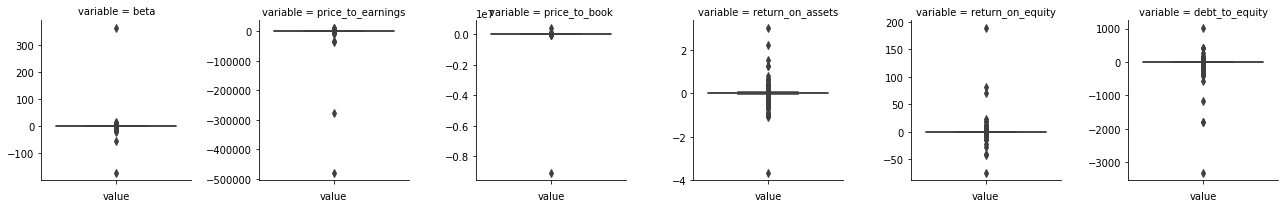

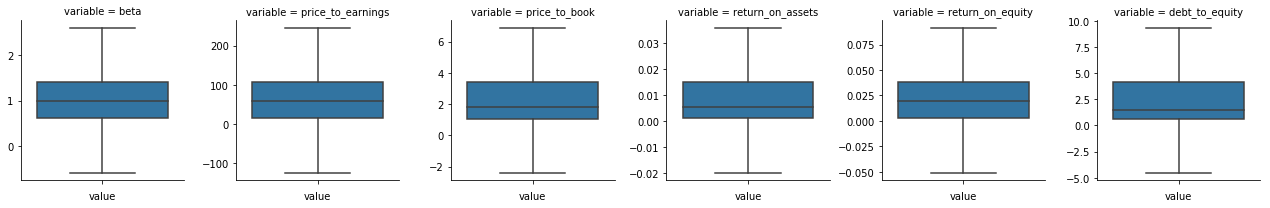

In [12]:
boxplot_features = ['beta', 'price_to_earnings', 'price_to_book', 'return_on_assets', 'return_on_equity', 'debt_to_equity']

sns.FacetGrid(
    data=pd.melt(financial_ratios[boxplot_features]),
    col='variable',
    sharey=False).map(
      sns.boxplot,
      'value',
      orient='v',)

sns.FacetGrid(
    data=pd.melt(financial_ratios[boxplot_features]),
    col='variable',
    sharey=False).map(
      sns.boxplot,
      'value',
      orient='v', showfliers=False)

The top grid shows the plots with their outliers, while the bottom shows the same plots **without** their outliers. We don't want to remove these outliers just yet because they may end up being helpful to our model. But as we see keeping them may make it impossible to visually graph and interpret our data. So we're going to remove them from our graphs so we can make a better analysis. We're using a slightly larger iqr multiplier than is usually used because we do we still wan to see how these outliers effect our data.

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `ord

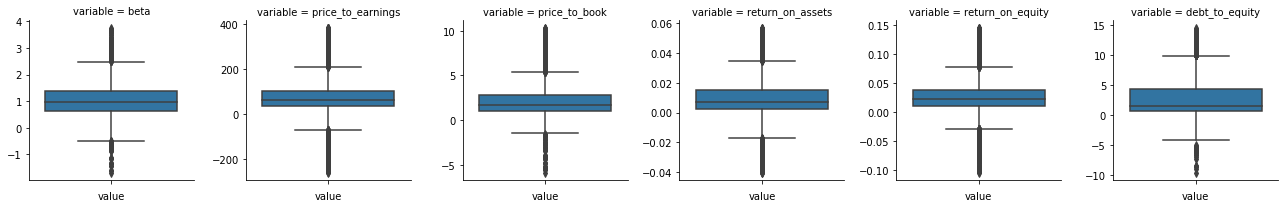

In [13]:
from scipy import stats

# return only columns with numbers
numeric_columns = financial_ratios.select_dtypes('number')

# copy financial_ratios dataframe
financial_ratios_removed_outliers = financial_ratios.copy(deep=True)

for col in numeric_columns:
    q1 = financial_ratios[col].quantile(.25)
    q3 = financial_ratios[col].quantile(.75)
    iqr = q3-q1

    low_outliers = financial_ratios[col] >= q1-(3*iqr)
    high_outliers = financial_ratios[col] <= q3+(3*iqr)

    financial_ratios_removed_outliers = financial_ratios_removed_outliers[low_outliers & high_outliers]

sns.FacetGrid(
    data=pd.melt(financial_ratios_removed_outliers[boxplot_features]),
    col='variable',
    sharey=False).map(
      sns.boxplot,
      'value',
      orient='v',)

### Showing Relationships

Now we're going to view all the features in relation to one another. But first we're going to sample the data to remove some of the noise caused by too many data points.

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


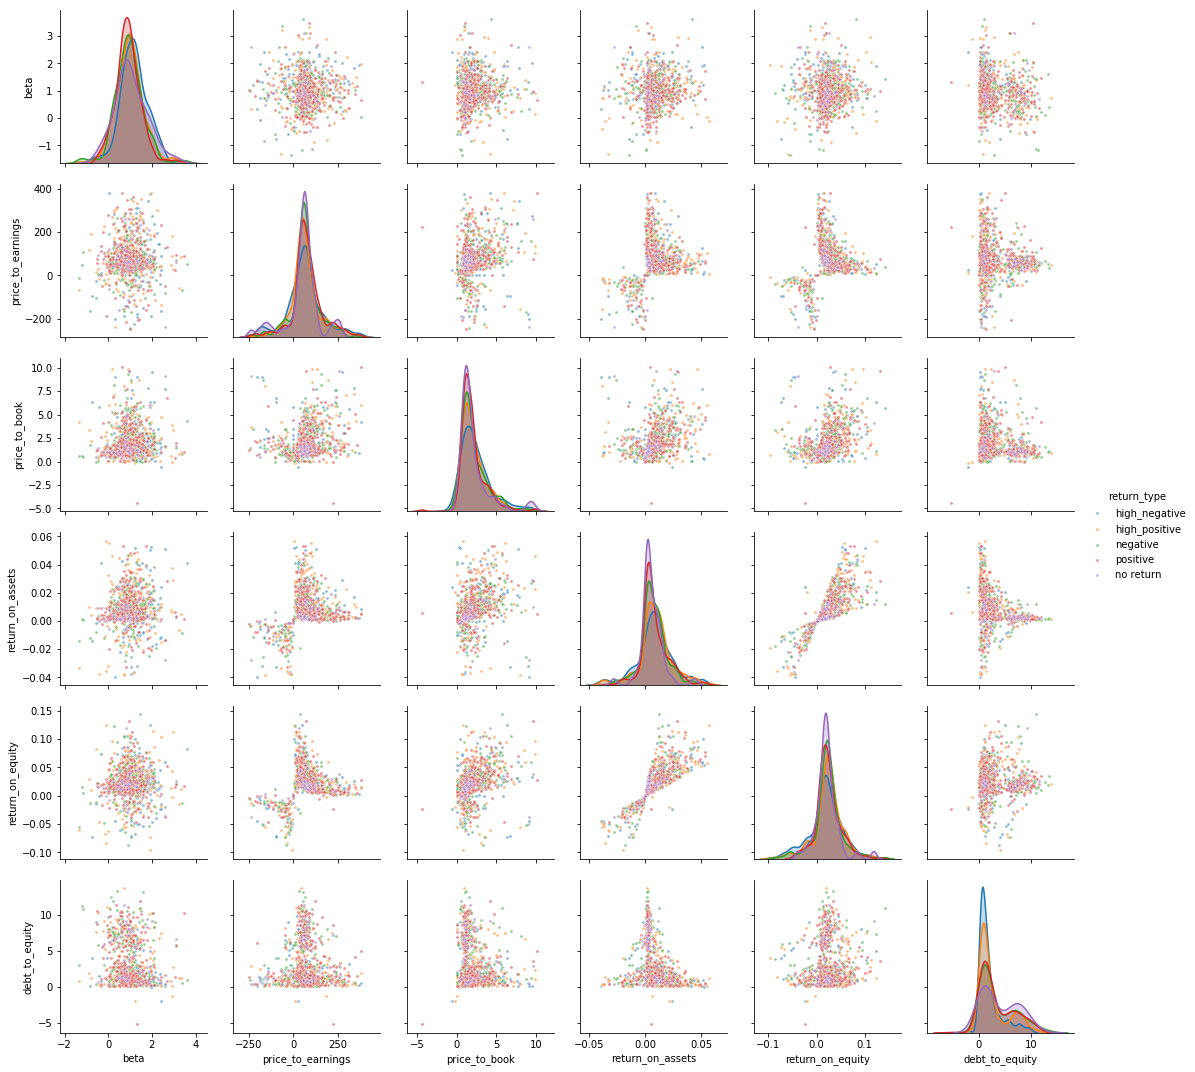

In [14]:
sampled_financial_ratios = financial_ratios_removed_outliers.sample(n=1000, random_state=1205)

sns.pairplot(sampled_financial_ratios,
    hue='return_type',
    plot_kws={
      'alpha':.5,
      's':10,
      },
    )

## Model Evaluation and Selection

In [15]:
# imports

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Before we go any further we have to create dummies variables out of our sector column to give us a way to use the data in our model.

In [16]:
financial_ratios_dummies = pd.get_dummies(financial_ratios, columns=['sector'])

### Train Test Split
Now that we've gotten our data in a form we like we're going break it into a training set and a testing set of data.

In [17]:
labels = ['high_negative', 'negative', 'no_return', 'positive', 'high_positive']

X = financial_ratios_dummies.drop('return_type', axis=1)
y = financial_ratios_dummies['return_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1205)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Metric
We're going to use **precision** as our metric for determining the effectiveness of the model. Because chances are that we're not going to buy every stock that comes up positive or high positive. That means we care less about correctly predicting every positive or high positive stock and more about not getting negative or high negative returns.

In [18]:
### Establishing a Baseline

In [19]:
y_null = np.full(y_test.shape, y_train.value_counts().index[0])
base_accuracy = metrics.accuracy_score(y_test, y_null)
base_precision = metrics.precision_score(y_test, y_null, labels=labels, average='weighted')

print(base_accuracy)
print(base_precision)

0.2846223021582734
0.08482387818558712


C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Model Selection

In [20]:
def fit_evaluate(model):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions and evalute
    model_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, model_pred)
    precision = metrics.precision_score(y_test, model_pred, labels=labels, average='weighted')

    # Return the performance metric
    return accuracy, precision

In [21]:
# SVC
fit_evaluate(SVC())

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3273381294964029, 0.1873994791736629)

In [22]:
# Random Forest
fit_evaluate(RandomForestClassifier(random_state=1205))

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.28597122302158273, 0.28801006049323424)

In [23]:
# K Nearest Neighbors
fit_evaluate(KNeighborsClassifier(n_jobs=-1,))

C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.28821942446043164, 0.28874793659760184)

#### Cross Fold Validation

## Model Results

Now that we've fit the model we can take a look at how it faired against our baseline precision of 0.085.

In [24]:
knn_model = KNeighborsClassifier()
parameters = {
    'n_neighbors': range(5, 50),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree',],
    'p': [1,2]}

knn_clf = GridSearchCV(
    estimator = knn_model,
    param_grid=parameters,
    cv=5,
    verbose=1,)

knn_clf.fit(X_train, y_train)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed: 36.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(5, 50), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
print(knn_clf.best_params_)
print(knn_clf.best_score_)

{'algorithm': 'auto', 'n_neighbors': 31, 'p': 2, 'weights': 'uniform'}
0.3065047961630695


### Graphing Results

In [26]:
from functions.visualization.confusion_matrix import * 

In [27]:
knn_clf_y_pred = knn_clf.predict(X_test)

print(f'accuracy score - {metrics.accuracy_score(y_test, knn_clf_y_pred)}')
print(f"precision score - {metrics.precision_score(y_test, knn_clf_y_pred, labels=labels, average='weighted')}")

accuracy score - 0.3376798561151079
precision score - 0.33148985213268495


C:\Users\Tyler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


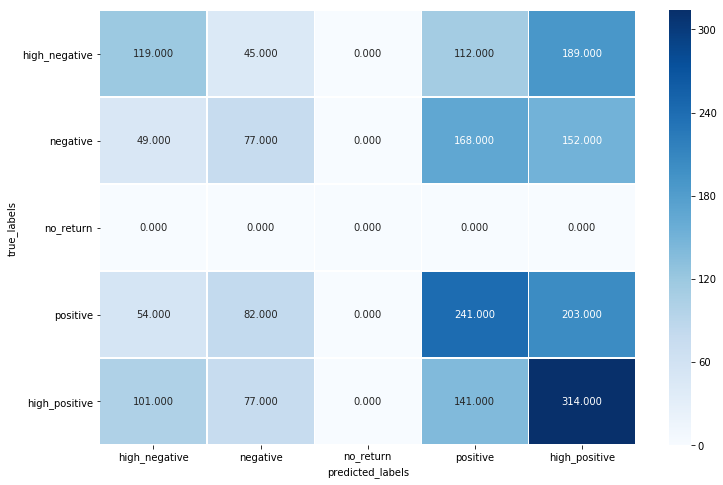

In [28]:
true_numbers = confusion_heatmap(y_test, knn_clf_y_pred, labels=labels, normalize=False)

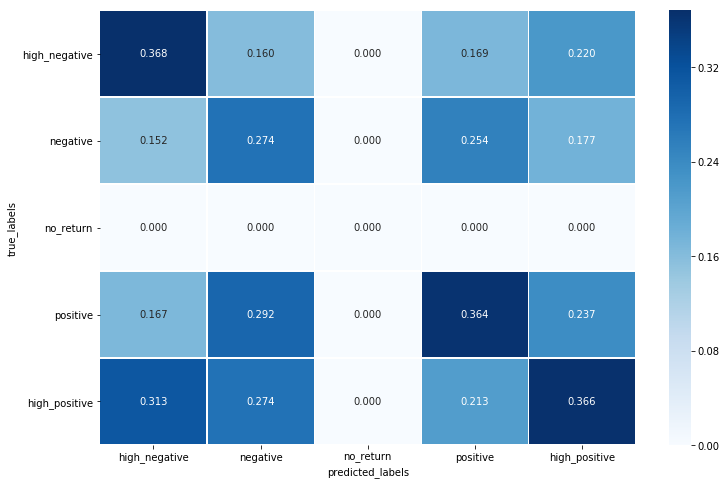

In [29]:
prediction_normalized = confusion_heatmap(y_test, knn_clf_y_pred, labels=labels, normalize='precision')

## Model Interpretation

The first thing we notice is that the model didn't predict any of our values as no_return. This isn't that big of a deal because the no_return value was mostly intended as a buffer between positive and negative values.

Next we're going to look at the top right corner because that's the where we worried about seeing values. About 40% of our values predicted as either high positive or positve are were actual negative values. This is not that great of a result for our model because if we were to use it we'd have a 40% chance of losing money on our investments.

## Improving the model
My next step would be to try and gather more data points from the sec files. When I complied them into my dataset I got rid of many points simply because they didn't have all the financial figures I needed. But I know there are some ways to retrieve some of those numbers with what is in the files. Even if those features aren't obtainable for every filing there absence might still be important to there stock value.

During the cleaning process I had to remove rows because they divided by 0 or became infinite. So adding those back into the model would also help to improve its performance.

Secondly, I would try to add more features for the model from the sec files. I only included the most common financial ratio figures for my features. There were many ratios that are important to consider but they weren't easily obtainable from the data I had.

I would really like to find a feature that is good at separating the high positive values from the high negative values. The model tends to classify those values together more commonly than by simple chance. From my analysis the features for both of them tend to align very closely.

Adding a predicted beta. Currently the model is predicting with just the daily beta from the previous quarter. Creating a beta that is better match for the actual beta for the quarter we're predicting on would help to improve the model.